# Week 5: Evaluation
#### Load the book targeting data
Note: these data are from a marketing campaign by a website that sells books. This website experimented with different promotions to try to learn which promotions work best for which customers.
#### Develop a model to predict whether the customer bought the promoted book (“promotedbook” == 1)
    Inspect the data, especially the distribution of the outcome variable
    Deal with missing records
    Scale the features
    Compare the following metrics: accuracy, recall, and precision. Why do these differ? (Tip: examine the confusion matrix)
    Find the model that produces the best F score (tip: set “scoring” attribute in cross-validation or grid search functions to “f1”)
#### Analyze the ROC and Profit curves
    Include a baseline model to compare with your best model
    For the Profit curve, pick your own cost-benefit matrix and in a note, briefly justify your choices
    Identify the ideal probability threshold, and interpret how your best model performs in comparison to the baseline model
#### Variable definitions:
    message_loss = promotional message emphasized lost opportunity if reader did not buy the book
    message_gain = promotional message emphasized gains if reader did buy the book
    romance_reader / fantasy_reader / realistic_reader = % of reader's prior books in each of these genres

In [1]:
# data packages
import pandas as pd
import numpy as np
import time

# algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# organizing tests
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# some metrics
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

# ROC curve
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.tree import plot_tree
from matplotlib import pyplot as plt

#new modules
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


In [2]:
# there are a lot of other metrics!
import sklearn.metrics
# dir(sklearn.metrics)

## Setup

In [3]:
# Load the book targeting dataPreview the document
df = pd.read_csv('book_targeting.csv')
print(df.shape)
cols = df.columns.to_list()
print(len(cols), 'columns:', cols)
df.head()

(17626, 12)
12 columns: ['promotedbook', 'message_loss', 'message_gain', 'prior_paymenttraj', 'priorpageview', 'loginpriorlogin', 'priorspending', 'priorbooks', 'date', 'romance_reader', 'fantasy_reader', 'realistic_reader']


,promotedbook,message_loss,message_gain,prior_paymenttraj,priorpageview,loginpriorlogin,priorspending,priorbooks,date,romance_reader,fantasy_reader,realistic_reader
0,0.0,0.0,1.0,2.0,3664.0,128.0,366.0,68.0,31,0.088235,0.897059,0.014706
1,0.0,0.0,0.0,3.0,1425.0,49.0,13140.0,7.0,28,0.857143,0.142857,0.000000
2,0.0,1.0,0.0,1.0,5.0,3.0,0.0,1.0,2,1.000000,0.000000,0.000000
3,0.0,0.0,0.0,3.0,1817.0,69.0,14203.0,36.0,23,0.181818,0.727273,0.090909
4,0.0,0.0,0.0,1.0,171.0,10.0,0.0,4.0,8,0.250000,0.000000,0.750000


In [4]:
# Fix missing records
df.fillna(0, inplace=True)

In [5]:
df.describe()

,promotedbook,message_loss,message_gain,prior_paymenttraj,priorpageview,loginpriorlogin,priorspending,priorbooks,date,romance_reader,fantasy_reader,realistic_reader
count,17626.000000,17626.000000,17626.000000,17626.000000,17626.000000,17626.000000,17626.000000,17626.000000,17626.000000,17626.000000,17626.000000,17626.000000
mean,0.030807,0.338023,0.332861,2.105923,1166.083797,56.412856,5297.370419,22.679621,19.321854,0.283991,0.522770,0.165836
std,0.172799,0.473050,0.471250,0.868201,1104.773917,63.718220,5364.604939,41.583065,11.636541,0.323688,0.372697,0.278745
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,144.000000,9.000000,0.000000,3.000000,6.000000,0.000000,0.153846,0.000000
50%,0.000000,0.000000,0.000000,2.000000,934.000000,43.000000,3974.000000,9.000000,25.000000,0.142857,0.548703,0.028571
75%,0.000000,1.000000,1.000000,3.000000,1786.750000,73.000000,8530.000000,22.000000,30.000000,0.500000,0.888889,0.200000
max,1.000000,1.000000,1.000000,3.000000,5194.000000,852.000000,46960.000000,480.000000,31.000000,1.000000,1.000000,1.000000


# Develop a model to predict whether the customer bought the promoted book 

In [6]:
# Inspect the data, especially the distribution of the outcome variable

print(df.promotedbook.value_counts(), '\n')
posrt = (df.promotedbook.sum()/len(df.index)).round(3)
print('proportion in positive class:', posrt)
print('baseline accuracy:', 1-posrt)

0.0    17083
1.0      543
Name: promotedbook, dtype: int64 

proportion in positive class: 0.031
baseline accuracy: 0.969


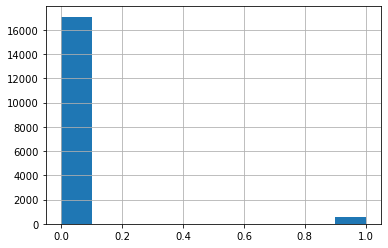

In [7]:
hist = df.promotedbook.hist()

In [8]:
# train-test split
# put all the predictive features in a list
xcols = df.columns[1 : len(df.columns)].to_list()
print(xcols,'\n')

# split the data into training (80%) and testing (20%) portions
# notes: train_test_split shuffles the data prior to splitting, so should be randomized
# the 'random_state' feature ensures that you get the same split of the data every time
X_train, X_test, y_train, y_test = train_test_split(df[xcols], df['promotedbook'], 
                                                    train_size=0.8, random_state=1)
print('training data:', X_train.shape)
print('test data:', X_test.shape)


['message_loss', 'message_gain', 'prior_paymenttraj', 'priorpageview', 'loginpriorlogin', 'priorspending', 'priorbooks', 'date', 'romance_reader', 'fantasy_reader', 'realistic_reader'] 

training data: (14100, 11)
test data: (3526, 11)


## Model1: Logistic regression 

In [9]:
# logistic regression
# initialize the logistic regression model
log_reg = LogisticRegression(solver='lbfgs', max_iter=1000)
# fit the model to the training data
log_clf = log_reg.fit(X_train, y_train)
# get accuracy stats
print('training accuracy: {}'.format(log_clf.score(X_train, y_train).round(4)))
print('test accuracy: {}'.format(log_clf.score(X_test, y_test).round(4)))

training accuracy: 0.9678
test accuracy: 0.9728


In [10]:
# put the coefficients into a new dataframe
coef = pd.concat([pd.DataFrame(xcols),pd.DataFrame(np.transpose(log_clf.coef_))], axis = 1)
coef.columns = ['feature','coefficient']
coef.sort_values(by=['coefficient'], ascending=False, inplace=True)
# examine the features with the largest coefficients
print('Ten largest positive features:\n', coef.head(10), '\n')
print('Ten largest negative features:\n', coef.tail(10))

Ten largest positive features:
               feature  coefficient
7                date     0.098057
6          priorbooks     0.011146
5       priorspending     0.000017
3       priorpageview    -0.000192
4     loginpriorlogin    -0.002155
0        message_loss    -0.015024
2   prior_paymenttraj    -0.246265
1        message_gain    -0.722173
8      romance_reader    -0.894885
10   realistic_reader    -1.054247 

Ten largest negative features:
               feature  coefficient
6          priorbooks     0.011146
5       priorspending     0.000017
3       priorpageview    -0.000192
4     loginpriorlogin    -0.002155
0        message_loss    -0.015024
2   prior_paymenttraj    -0.246265
1        message_gain    -0.722173
8      romance_reader    -0.894885
10   realistic_reader    -1.054247
9      fantasy_reader    -1.383554


In [11]:
# minmax scaler normalizes data to range from 0-1
#  subtracts each value from the feature's minimum and then divides by the feature's range
#  then scales 
# initialize the scaler function
scaler = MinMaxScaler()
# transform data
# note: it is important to do this separately for training and testing data
#  in order to prevent data leakage, whereby training data contains info about test data
scaled_train = scaler.fit_transform(X_train)
scaled_test = scaler.fit_transform(X_test)

In [12]:
##### redo the logistic regression w/ normalized data
log_clf = log_reg.fit(scaled_train, y_train)
print('training accuracy: {}'.format(log_clf.score(scaled_train, y_train).round(4)))
print('test accuracy: {}'.format(log_clf.score(scaled_test, y_test).round(4)))

# re-examine coefficients
coef = pd.concat([pd.DataFrame(xcols),pd.DataFrame(np.transpose(log_clf.coef_))], axis = 1)
coef.columns = ['feature','coefficient']
coef.sort_values(by=['coefficient'], ascending=False, inplace=True)
print('Ten largest positive features:\n', coef.head(5), '\n')
print('Ten largest negative features:\n', coef.tail(5))

training accuracy: 0.9682
test accuracy: 0.9731
Ten largest positive features:
            feature  coefficient
6       priorbooks     2.906867
7             date     2.783276
4  loginpriorlogin     0.772447
5    priorspending     0.329795
0     message_loss     0.273361 

Ten largest negative features:
               feature  coefficient
10   realistic_reader    -0.112374
2   prior_paymenttraj    -0.299072
8      romance_reader    -0.303899
9      fantasy_reader    -0.327120
3       priorpageview    -0.685463


In [13]:
xcols2 = coef.feature[0:5].to_list()
xcols2 += coef.feature[-5:].to_list()
print(xcols2)

['priorbooks', 'date', 'loginpriorlogin', 'priorspending', 'message_loss', 'realistic_reader', 'prior_paymenttraj', 'romance_reader', 'fantasy_reader', 'priorpageview']


In [14]:
# cross-validation w/ tuning regularization in logistic regression
cset = [.001, .01, .1, 1, 10]
for i in cset:
    print('C =', i)
    log_clf = LogisticRegression(solver='lbfgs', max_iter=1000, C=i)
    scores = cross_val_score(log_reg, df[xcols2], df['promotedbook'], cv=5)
    print(scores)
    print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2), '\n')

C = 0.001
[0.96880318 0.9693617  0.9693617  0.96765957 0.96851064]
Accuracy: 0.969 (+/- 0.001) 

C = 0.01
[0.96880318 0.9693617  0.9693617  0.96765957 0.96851064]
Accuracy: 0.969 (+/- 0.001) 

C = 0.1
[0.96880318 0.9693617  0.9693617  0.96765957 0.96851064]
Accuracy: 0.969 (+/- 0.001) 

C = 1
[0.96880318 0.9693617  0.9693617  0.96765957 0.96851064]
Accuracy: 0.969 (+/- 0.001) 

C = 10
[0.96880318 0.9693617  0.9693617  0.96765957 0.96851064]
Accuracy: 0.969 (+/- 0.001) 



## Model2: SVM  

In [15]:
# support vector machine w/o normalized data
print(time.strftime("%a, %d %b %Y %H:%M:%S", time.localtime()))
svm = SVC(kernel = 'linear')
#fit the model to the training data
svm_clf = svm.fit(X_train, y_train)
# get accuracy stats
print('training accuracy: {}'.format(svm_clf.score(X_train, y_train).round(3)))
print('test accuracy: {}'.format(svm_clf.score(X_test, y_test).round(3)))
print(time.strftime("%a, %d %b %Y %H:%M:%S", time.localtime()))

Mon, 08 Mar 2021 02:08:56
training accuracy: 0.96
test accuracy: 0.964
Mon, 08 Mar 2021 02:17:44


In [18]:
# support vector machine w/ normalized data
print(time.strftime("%a, %d %b %Y %H:%M:%S", time.localtime()))
svm_clf = svm.fit(scaled_train, y_train)
print('training accuracy: {}'.format(svm_clf.score(scaled_train, y_train).round(3)))
print('test accuracy: {}'.format(svm_clf.score(scaled_test, y_test).round(3)))
print(time.strftime("%a, %d %b %Y %H:%M:%S", time.localtime()))

Mon, 08 Mar 2021 02:21:03
training accuracy: 0.968
test accuracy: 0.973
Mon, 08 Mar 2021 02:21:04


In [19]:
# examine coefficients for SVM Model
coef = pd.concat([pd.DataFrame(xcols),pd.DataFrame(np.transpose(svm_clf.coef_))], axis = 1)
coef.columns = ['feature','coefficient']
coef.sort_values(by=['coefficient'], ascending=False, inplace=True)
print('Ten largest positive features:\n', coef.head(5), '\n')
print('Ten largest negative features:\n', coef.tail(5))

Ten largest positive features:
              feature  coefficient
4    loginpriorlogin     0.000680
7               date     0.000155
2  prior_paymenttraj     0.000098
8     romance_reader     0.000081
3      priorpageview     0.000050 

Ten largest negative features:
              feature  coefficient
5      priorspending    -0.000024
9     fantasy_reader    -0.000025
10  realistic_reader    -0.000054
0       message_loss    -0.000067
6         priorbooks    -0.000591


In [20]:
# normalization + regularization w/ the C parameter (note: default C = 1)
cset = [.001, .01, .1, 1, 10, 100]
for i in cset:
    print('C =', i)
    svm = SVC(kernel = 'linear', C = i)
    svm_clf = svm.fit(scaled_train, y_train)
    print('training accuracy: {}'.format(svm_clf.score(scaled_train, y_train).round(3)))
    print('test accuracy: {}'.format(svm_clf.score(scaled_test, y_test).round(3)), '\n')

C = 0.001
training accuracy: 0.968
test accuracy: 0.973 

C = 0.01
training accuracy: 0.968
test accuracy: 0.973 

C = 0.1
training accuracy: 0.968
test accuracy: 0.973 

C = 1
training accuracy: 0.968
test accuracy: 0.973 

C = 10
training accuracy: 0.968
test accuracy: 0.973 

C = 100
training accuracy: 0.968
test accuracy: 0.973 



In [17]:
xcols2 = coef.feature[0:5].to_list()
xcols2 += coef.feature[-5:].to_list()
print(xcols2)

['priorbooks', 'date', 'loginpriorlogin', 'priorspending', 'message_loss', 'realistic_reader', 'prior_paymenttraj', 'romance_reader', 'fantasy_reader', 'priorpageview']


In [ ]:
# cross-validation w/ tuning regularization in SVM
cset = [.001, .01, .1, 1, 10]
for i in cset:
    print('C =', i)
    svm = SVC(kernel = 'linear', C = i)
    scores = cross_val_score(svm, df[xcols2], df['promotedbook'], cv=5, scoring = 'f1')
    print(scores)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

C = 0.001
[0. 0. 0. 0. 0.]
Accuracy: 0.00 (+/- 0.00)
C = 0.01


## Comparing evaluations
Compare the following metrics: accuracy, recall, and precision. Why do these differ? (Tip: examine the confusion matrix).

Find the model that produces the best F score (tip: set “scoring” attribute in cross-validation or grid search functions to “f1”)



In [15]:
# Chosing the Log Reg model after cross validation

# let's check out some other stats for the test data
# note: we first get the predicted values and then pass these to each metric w/ the actual values

log_reg = LogisticRegression(solver='lbfgs', max_iter=1000, C=.1)
log_clf = log_reg.fit(df[xcols], df['promotedbook'])

y_pred_testlog = log_clf.predict(X_test)
print('  Recall: {:.3f}'.format(recall_score(y_test, y_pred_testlog)))
print('  Precision: {:.3f}'.format(precision_score(y_test, y_pred_testlog)))
print('  F1 score: {:.3f}'.format(f1_score(y_test, y_pred_testlog)))
cm = confusion_matrix(y_test, y_pred_testlog)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn+fp)
print('  Specificity: {:.3f}'.format(specificity))

  Recall: 0.011
  Precision: 0.500
  F1 score: 0.021
  Specificity: 1.000


In [16]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred_testlog)
sample = np.array([['TN', 'FP'], ['FN', 'TP']])
print('CM key:\n', sample, '\n')
print('CM for test:\n', cm)

CM key:
 [['TN' 'FP']
 ['FN' 'TP']] 

CM for test:
 [[3431    1]
 [  93    1]]


In [24]:
# Chosing the SVM model after cross validation

svm = SVC(kernel = 'linear', C = .1, probability=True)
svm_clf = svm.fit(df[xcols], df['promotedbook'])

y_pred_testsvm = svm_clf.predict(X_test)
print('  Recall: {:.3f}'.format(recall_score(y_test, y_pred_testsvm)))
print('  Precision: {:.3f}'.format(precision_score(y_test, y_pred_testsvm)))
print('  F1 score: {:.3f}'.format(f1_score(y_test, y_pred_testsvm)))
cm = confusion_matrix(y_test, y_pred_testsvm)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn+fp)
print('  Specificity: {:.3f}'.format(specificity))

  Recall: 0.000
  Precision: 0.000
  F1 score: 0.000
  Specificity: 0.998


In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred_testsvm)
sample = np.array([['TN', 'FP'], ['FN', 'TP']])
print('CM key:\n', sample, '\n')
print('CM for test:\n', cm)

The accuracy, recall, and precision differ for Model1 (Log) and Model2 (SVM) because the number of true negatives & postives , false negatives & positives are different in both models. 

The second model using SVM has the best F1 score of .075 , C = 0.1.

## Remedying class imbalance

### Modify algorithm approach

In [ ]:
# modify the algorithm's objective w/ class_weight attribute
svm = SVC(kernel = 'linear', C = 0.1)
clf = svm.fit(X_train, y_train)
print('training accuracy: {}'.format(clf.score(X_train, y_train).round(4)))
print('test accuracy: {}'.format(clf.score(X_test, y_test).round(4)))
print('other test stats:')
y_pred_test = clf.predict(X_test)
print('  Recall: {:.3f}'.format(recall_score(y_test, y_pred_test)))
print('  Precision: {:.3f}'.format(precision_score(y_test, y_pred_test)))
print('  F1 score: {:.3f}'.format(f1_score(y_test, y_pred_test)))
cm = confusion_matrix(y_test, y_pred_test)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn+fp)
print('  Specificity: {:.3f}'.format(specificity))
print('confusion matrix:\n', cm)

### Modify sample approach

In [ ]:
# uncomment and run this code to install package for ML w/ imbalanced data
#!pip install imblearn

In [ ]:
# random oversampling: randomly add cases from the minority (sampling w/ replacement) to achieve desired balance
from imblearn.over_sampling import RandomOverSampler

# setup data and examine distribution of outcome
X, y = df[xcols], df['promotedbook']
print(y.value_counts())

# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
#oversample = RandomOverSampler(sampling_strategy=0.5) # can also oversample to achieve a ratio < 1:1 
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X, y)

# new class distribution
print(y_over.value_counts())

In [ ]:
# examine results
# note: new variables passed to train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, 
                                                    random_state=0)
print('train shape:', X_train.shape)
print('test shape:', X_test.shape, '\n')

svm = SVC(kernel = 'linear', C = 0.1)
clf = svm.fit(X_train, y_train)
print('training accuracy: {}'.format(clf.score(X_train, y_train).round(4)))
print('test accuracy: {}'.format(clf.score(X_test, y_test).round(4)))
print('other test stats:')
y_pred_test = clf.predict(X_test)
print('  Recall: {:.3f}'.format(recall_score(y_test, y_pred_test)))
print('  Precision: {:.3f}'.format(precision_score(y_test, y_pred_test)))
print('  F1 score: {:.3f}'.format(f1_score(y_test, y_pred_test)))
cm = confusion_matrix(y_test, y_pred_test)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn+fp)
print('  Specificity: {:.3f}'.format(specificity))
print('confusion matrix:\n', cm)

In [ ]:
# but how well does it do on the original dataset?
y_pred = clf.predict(X)
print('Accuracy: {:.3f}'.format(clf.score(X, y)))
print('Recall: {:.3f}'.format(recall_score(y, y_pred)))
print('Precision: {:.3f}'.format(precision_score(y, y_pred)))
print('F1 score: {:.3f}'.format(f1_score(y, y_pred)))
cm = confusion_matrix(y, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn+fp)
print('Specificity: {:.3f}'.format(specificity))
print('confusion matrix:\n', cm)
# how could this have been done better?

## ROC Curves

In [ ]:
# simple ROC curve for 1 estimator
svm = SVC(kernel = 'linear', C = 0.1)
clf = svm.fit(X_train, y_train)

plot_roc_curve(clf, X_test, y_test)
x = np.linspace(0,1.0)
plt.plot(x, x, color='grey',ls='--')
plt.show()

In [ ]:
from sklearn.tree import export_text

#fit the decision tree and output accuracy constrained by depth
clf = DecisionTreeClassifier(criterion='entropy', max_depth=6).fit(X, y)
print('Accuracy of Decision Tree classifier: {:.2f}'
     .format(clf.score(X, y)))

r = export_text(clf, feature_names=xcols)
print(r)

In [ ]:
# summarize feature importance, and store values under feature names in scores dictionary
importance = clf.feature_importances_
scores = {}
for i,v in enumerate(importance):
    #print('Feature: %s, Score: %.5f' % (xcols[i],v))
    scores[xcols[i]] = v

#reverse sort 'scores' dictionary by values
import operator
sorted_scores = sorted(scores.items(), key=operator.itemgetter(1),reverse=True)

#print top 10 features
for feature, score in sorted_scores[0:10]:
    print(feature, ':', score)

### I have chosen "priorbooks" as baseline Model

In [ ]:
# full model
svm = SVC(kernel = 'linear', C = 0.1)
clf = svm.fit(X_train, y_train)
lr_probs = clf.predict_proba(X_test)

# 1 feature model
svm = SVC(kernel = 'linear', C = 0.1)
X_train2 = X_train[['priorbooks']]
X_test2 = X_test[['priorbooks']]
clf2 = log_reg2.fit(X_train2, y_train)
lr_probs2 = clf2.predict_proba(X_test2)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
lr_probs2 = lr_probs2[:, 1]
# calculate scores
lr_auc = roc_auc_score(y_test, lr_probs)
lr_auc2 = roc_auc_score(y_test, lr_probs2)
# summarize scores
print('Full model: ROC AUC=%.3f' % (lr_auc))
print('1 feature: ROC AUC=%.3f' % (lr_auc2))

In [ ]:
# Plot ROC curves
# get the false positve rates and true positive rates for each model
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
lr_fpr2, lr_tpr2, _ = roc_curve(y_test, lr_probs2)
# plot the roc curves for the model
plt.plot(lr_fpr, lr_tpr, linestyle='--', label='Full model')
plt.plot(lr_fpr2, lr_tpr2, marker='.', label='1 feature')
# plot title
plt.title('ROC Curves')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# add a diagonal line
x = np.linspace(0, 1.0)
plt.plot(x, x, color='grey', ls='--')
# show the plot
plt.show()

## Profit curves

In [ ]:
# Get model probability predictions for positive class
# Note: uses models created in prior step and stored under 'clf' and 'clf2'
y_proba = clf.predict_proba(X_test)[:, 1]
y_proba2 = clf2.predict_proba(X_test2)[:, 1]

# Define cost-benefit matrix
# format: [[tn, fp], [fn, tp]]
# signing a potential allstar costs 8000 duckets, but is worth 12,000
costbenefit_mat = [[0, -8000], [0, 4000]]
    
# Profit curve data
profits = [] # one profit value for each T (threshold)
# sort probabilities into descending order
thresholds = sorted(y_proba, reverse=True)

# For each threshold, calculate profit - starting with largest threshold
for T in thresholds:
    y_pred = (y_proba > T).astype(int)
    # Calculate confusion matrix for this probability threshold
    #[[tn, fp], [fn, tp]] = confusion_matrix(y_test, y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred)
    # Calculate total profit for this threshold
    profit = sum(sum(confusion_mat * costbenefit_mat)) / len(y_test)
    profits.append(profit)

# Repeat for 2nd model (should put this into a function instead)
profits2 = [] # one profit value for each T (threshold)
thresholds2 = sorted(y_proba2, reverse=True)
for T in thresholds2:
    y_pred2 = (y_proba2 > T).astype(int)
    confusion_mat2 = confusion_matrix(y_test, y_pred2)
    profit2 = sum(sum(confusion_mat2 * costbenefit_mat)) / len(y_test)
    profits2.append(profit2)

# Profit curve plot
model_name = 'Full model'
max_profit = max(profits).round(2)
model_name2 = '1 feature'
max_profit2 = max(profits2).round(2)
plt.figure(figsize=(10, 10))
plt.plot(np.linspace(0, 1, len(y_test)), profits, label = '{}, max profit ${} per user'.format(model_name, max_profit))
plt.plot(np.linspace(0, 1, len(y_test)), profits2, label = '{}, max profit ${} per user'.format(model_name2, max_profit2))
plt.xlabel('Percentage of test instances (decreasing by score)')
plt.ylabel('Profit')
plt.title('Profit Curves')
plt.legend(loc='lower left')
plt.show()